# Create WecOptTool Model for the Marson WEC concept

In [20]:
import numpy as np
import capytaine as cpt
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh
import os
import xarray as xr

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

import logging
logging.getLogger().setLevel(logging.INFO)

In [21]:
# set frequencies
wCapy =  np.linspace(0.04, 10.0, 100)                  # wave frequencies - also used to specify the lid position

-0.0914539114058809
FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_6516"), lid_mesh=Mesh(..., name="lid for Rect"), dofs={"Surge": ..., "Sway": ..., "Heave": ..., "Roll": ..., "Pitch": ..., "Yaw": ...}, center_of_mass=[-5.  0.  0.], name="rect")
-0.09145391140588087
FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_6536"), lid_mesh=Mesh(..., name="lid for Rect"), dofs={"Surge": ..., "Sway": ..., "Heave": ..., "Roll": ..., "Pitch": ..., "Yaw": ...}, center_of_mass=[-15.   0.   0.], name="rect")


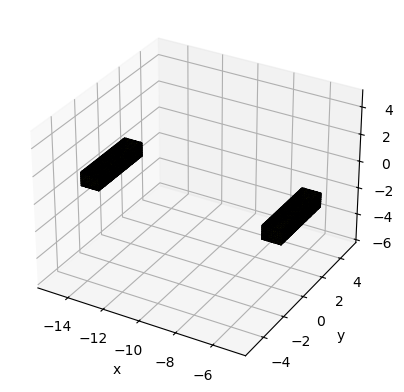

In [22]:
## Input parameters for geometry
numBodies = 2
bodyDist = 10 # distanc between each body's cg
bodyLocs = [-0.5*bodyDist, -1.5*bodyDist] # assumes bodies are connected to stationary PTO at x=0
mesh_size_factor = 0.14 # works well for this size 
depth = 2
bodDraft = [1, 1]#, 1]
bodWidth = [1, 1]#, 1]
bodLength = [2, 2]#, 2]

hydrostaticsDict = {}
rect = {}
bodList = [] 

for nBod in range(numBodies):
    with pygmsh.geo.Geometry() as geom:
        poly1 = geom.add_polygon(
            [[bodyLocs[nBod]-bodWidth[nBod]/2, bodLength[nBod]],
            [bodyLocs[nBod]-bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,bodLength[nBod]]],mesh_size=mesh_size_factor)
        
        geom.translate(poly1, [0, 0, depth-bodDraft[nBod]])
        geom.extrude(poly1,[0,0,-depth])
        rectMesh = geom.generate_mesh()
        meshObj = load_from_meshio(rectMesh, 'Rect')
        lid_pos = meshObj.lowest_lid_position(max(wCapy)) # add lid to reduce irregular frequency peaks
        print(lid_pos)
        lidMesh = meshObj.generate_lid(z=lid_pos)

        # define the floating body
        rect[nBod] = cpt.FloatingBody(mesh=rectMesh, lid_mesh = lidMesh, name="rect", center_of_mass=(bodyLocs[nBod], 0, 0))
        rect[nBod].keep_immersed_part()
        rect[nBod].rotation_center = rect[nBod].center_of_mass
        rect[nBod].add_all_rigid_body_dofs()
        print(rect[nBod])

        bodList.append(rect[nBod])

all_bodies = cpt.FloatingBody.join_bodies(*bodList)

all_bodies.show_matplotlib()

#all_bodies.show()

In [23]:
### Calculate hydrostatics
myBodies = bodList

for i in range(2):
    myBodies[i].keep_immersed_part()
    myBodies[i].add_all_rigid_body_dofs()

for i, body in enumerate(myBodies):
    cg = body.center_of_mass
    # Capytaine version is >= 2.0
    body_hs = body.compute_hydrostatics(rho=1023.0)
    vo = body_hs['disp_volume']
    cb = body_hs['center_of_buoyancy']
    khs = body_hs['hydrostatic_stiffness']

    # Write hydrostatic stiffness to KH.dat file
    khs_full = np.zeros((6,6))
    khs_full[2:5, 2:5] += khs[2:5, 2:5]

    tmp = 'KH' + '_' + str(i) +'.dat'
    np.savetxt(tmp, khs_full)

    # Write the other hydrostatics data to Hydrostatics.dat file
    tmp = 'Hydrostatics' + '_' + str(i) + '.dat'
    f = open(tmp,'w')
    for j in [0,1,2]:
        line =  f'XF = {cb[j]:7.3f} - XG = {cg[j]:7.3f} \n'
        f.write(line)
    line = f'Displacement = {vo:E}'
    f.write(line)
    f.close()

In [25]:
ncFName = 'attenuator2Bod.nc'

path,tmp = os.path.split(os.getcwd() + os.path.sep + ncFName)
path += os.path.sep

headings = np.linspace(0,np.pi/2,1)  

depth = np.infty
density = 1025.0

#print(wCapy)

# call Capytaine solver
print(f'\n-------------------------------\n'
      f'Calling Capytaine BEM solver...\n'
      f'-------------------------------\n'
      f'mesh = {all_bodies.name}\n'
      f'w range = {wCapy[0]:.3f} - {wCapy[-1]:.3f} rad/s\n'
      f'dw = {(wCapy[1]-wCapy[0]):.3f} rad/s\n'
      f'no of headings = {len(headings)}\n'
      f'no of radiation & diffraction problems = {len(wCapy)*(len(headings) + len(all_bodies.dofs))}\n'
      f'-------------------------------\n')

problems = xr.Dataset(coords={
    'omega': wCapy,
    'wave_direction': headings,
    'radiating_dof': list(all_bodies.dofs),
    'water_depth': [depth],
    'rho': [density],
    })

solver = cpt.BEMSolver()
capyData = solver.fill_dataset(problems, [all_bodies], hydrostatics=False)

# save to .nc file
cpt.io.xarray.separate_complex_values(capyData).to_netcdf(ncFName, encoding={'radiating_dof': {'dtype': 'U'}, 'influenced_dof': {'dtype': 'U'}})

print('\nCapytaine call complete. Data saved to \n' + ncFName +'\n\n')


-------------------------------
Calling Capytaine BEM solver...
-------------------------------
mesh = rect+rect
w range = 0.040 - 10.000 rad/s
dw = 0.101 rad/s
no of headings = 1
no of radiation & diffraction problems = 700
-------------------------------



[16:17:33] WARNING  Mesh resolution for 84 problems:                                                               
                    The resolution of the mesh might be insufficient for omega ranging from 8.893 to 10.000.       
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Output()


Capytaine call complete. Data saved to 
attenuator2Bod.nc




In [19]:
print(capyData['added_mass'])

<xarray.DataArray 'added_mass' (omega: 100, radiating_dof: 6, influenced_dof: 6)>
array([[[ 6.42755194e+03, -1.39394239e-01, -9.70218327e-01,
         -3.60366050e-01, -2.74427425e+03, -6.14473348e-01],
        [ 2.31297215e-01,  9.56450501e+02, -7.05435874e-02,
          1.20690573e+02, -9.27535617e-02, -8.01218858e-01],
        [ 8.40159754e-01,  9.44245703e-02,  2.94196096e+03,
         -3.24780288e-01, -5.45050408e-01, -2.72836617e-01],
        [ 5.83449735e-01,  1.21035664e+02, -8.20172594e-01,
          2.05683974e+03, -4.37157801e-01, -2.18081910e-01],
        [-2.74592147e+03, -6.22432386e-02,  1.13539711e+00,
          2.20476765e-01,  1.35341850e+03,  9.64003499e-01],
        [-6.87544433e-01,  1.31540943e+00,  4.33418367e-01,
         -6.85033802e-02,  4.94025938e-01,  5.28188095e+03]],

       [[ 6.43243140e+03, -1.36136909e-01, -9.72354876e-01,
         -3.61679622e-01, -2.74624250e+03, -6.15518097e-01],
        [ 2.30952958e-01,  9.57251056e+02, -7.40166259e-02,
         

In [43]:
dataset = xr.open_dataset('attenuator.nc')
print(dataset['added_mass'].values)

[[[ 6.42755194e+03 -1.39394239e-01 -9.70218327e-01 -3.60366050e-01
   -2.74427425e+03 -6.14473348e-01]
  [ 2.31297215e-01  9.56450501e+02 -7.05435874e-02  1.20690573e+02
   -9.27535617e-02 -8.01218858e-01]
  [ 8.40159754e-01  9.44245703e-02  2.94196096e+03 -3.24780288e-01
   -5.45050408e-01 -2.72836617e-01]
  [ 5.83449735e-01  1.21035664e+02 -8.20172594e-01  2.05683974e+03
   -4.37157801e-01 -2.18081910e-01]
  [-2.74592147e+03 -6.22432386e-02  1.13539711e+00  2.20476765e-01
    1.35341850e+03  9.64003499e-01]
  [-6.87544433e-01  1.31540943e+00  4.33418367e-01 -6.85033802e-02
    4.94025938e-01  5.28188095e+03]]

 [[ 6.43243140e+03 -1.36136909e-01 -9.72354876e-01 -3.61679622e-01
   -2.74624250e+03 -6.15518097e-01]
  [ 2.30952958e-01  9.57251056e+02 -7.40166259e-02  1.20355310e+02
   -9.28028996e-02 -8.01770191e-01]
  [ 8.41181448e-01  9.42720552e-02  2.96180246e+03 -3.24897405e-01
   -5.45336559e-01 -2.73142028e-01]
  [ 5.83606703e-01  1.20811210e+02 -8.31244591e-01  2.05690338e+03
   -

In [44]:
dataset = xr.open_dataset('sphere_full.nc')
print(dataset)
print(dataset['added_mass'])

<xarray.Dataset>
Dimensions:              (omega: 420, radiating_dof: 6, influenced_dof: 6,
                          complex: 2, wave_direction: 1)
Coordinates:
  * omega                (omega) float64 0.02 0.04 0.06 0.08 ... 8.36 8.38 8.4
    body_name            object ...
  * radiating_dof        (radiating_dof) object 'Surge' 'Sway' ... 'Pitch' 'Yaw'
  * influenced_dof       (influenced_dof) object 'Surge' 'Sway' ... 'Yaw'
  * complex              (complex) object 're' 'im'
  * wave_direction       (wave_direction) float64 0.0
    g                    float64 ...
    rho                  float64 ...
    water_depth          float64 ...
Data variables:
    added_mass           (omega, radiating_dof, influenced_dof) float64 ...
    radiation_damping    (omega, radiating_dof, influenced_dof) float64 ...
    diffraction_force    (complex, omega, wave_direction, influenced_dof) float64 ...
    Froude_Krylov_force  (complex, omega, wave_direction, influenced_dof) float64 ...
Attributes: